In [4]:
# pip install pymc3

Сказать про то, что на больших выборках большое смещение

In [134]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano
from statsmodels.discrete.discrete_model import Probit

warnings.filterwarnings("ignore")
theano.config.on_opt_error = "ignore"

#warnings.simplefilter(action="ignore", category=FutureWarning)

In [125]:
import theano.tensor as tsr

def probit_phi(x):
    
    mu = 0
    sd = 1
    
    return 0.5 * (1 + tsr.erf((x - mu) / (sd * tsr.sqrt(2))))

In [126]:
# функция для генерации выборки
def generate_sample(size=1000):
    x_0 = np.ones(shape=size)
    x_1 = np.random.normal(loc=3, scale=2, size=size)
    x_2 = np.random.uniform(low=1, high=3, size=size)
    X = np.vstack((x_0, x_1, x_2)).T
    
    betas = np.array([2, -1, 0.5])
    eps = np.random.normal(loc=0, scale=1, size=size) # предпосылка пробита

    y = (X @ betas + eps > 0) * 1

    probit_data = {'n': size,
                   'y': y,
                   'x_1': x_1,
                   'x_2': x_2
                  }
    
    return probit_data

print('Доля единиц в целевой переменной:', np.mean(generate_sample()['y']))

Доля единиц в целевой переменной: 0.488


In [135]:
def get_estimates(data, est=np.mean):

    with pm.Model() as model:

        beta0 = pm.Normal('beta0', mu=0, sigma=10)
        beta1 = pm.Normal('beta1', mu=0, sigma=10)
        beta2 = pm.Normal('beta2', mu=0, sigma=10)
    
        z = beta0 + beta1 * data['x_1'] + beta2 * data['x_2']
        probs = probit_phi(z)

        y = pm.Bernoulli('y', p=probs, observed=data['y'])
    
        step = pm.NUTS()
        trace = pm.sample(2000, chains=1, cores=-1, step=step, progressbar=True)
        # az.plot_trace(trace)
        return est(trace.get_values('beta0')), est(trace.get_values('beta1')), est(trace.get_values('beta2'))

In [136]:
np.random.seed(999)

data = generate_sample(100)
get_estimates(data)

Sequential sampling (1 chains in 1 job)
NUTS: [beta2, beta1, beta0]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 4 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


(2.028635572525393, -1.0579750758789224, 0.4794903809807282)

In [170]:
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse
from IPython.display import clear_output
from tqdm.auto import tqdm

params = ['beta0', 'beta1', 'beta2']
true_betas = [2, -1, 0.5]

def get_results(size, n_epochs=100):
    
    results_bayes = {'beta0': [],
                     'beta1': [],
                     'beta2': []
                    }
    results_ml = {'beta0': [],
                  'beta1': [],
                  'beta2': []
                  }
    
    total_bayes = []
    total_ml = []
    
    for epoch in range(n_epochs):
        print('Размер выборки:', size, '------ Эпоха', epoch + 1, 'из', n_epochs)
        
        data_new = generate_sample(size)
        
        # bayes
        coefs_bayes = get_estimates(data_new)
        for param in range(len(params)):
            results_bayes[params[param]].append(coefs_bayes[param])
            
        # maximum likelihood
        target = data_new['y']
        X_probit = np.vstack((np.ones(size), data_new['x_1'], data_new['x_2'])).T
        coefs_ml = Probit(target, X_probit).fit()
        for param in range(len(params)):
            results_ml[params[param]].append(coefs_ml.params[param])
        clear_output(wait=True)
        
    # подсчитываем метрики
    for i in range(len(params)):
        true_coef = np.ones(shape=n_epochs) * true_betas[i]
        total_bayes.append([params[i], 
                      mape(true_coef, results_bayes[params[i]]) * 100, # в процентах
                      mse(true_coef, results_bayes[params[i]], squared=False)])
        total_ml.append([params[i], 
                      mape(true_coef, results_ml[params[i]]) * 100, # в процентах
                      mse(true_coef, results_ml[params[i]], squared=False)])

    return total_bayes, total_ml


In [171]:
np.random.seed(999)

get_results(50, n_epochs=3)

([['beta0', 71.83278785937554, 1.7261501385697149],
  ['beta1', 64.71542374545635, 0.958926436534632],
  ['beta2', 158.47739847348413, 0.9770840222110082]],
 [['beta0', 59.8661089408835, 1.3786745757631647],
  ['beta1', 52.678033440451955, 0.6888370915126503],
  ['beta2', 128.80410470049438, 0.7416196946909385]])

In [176]:
np.random.seed(999)

all_metrics = {'bayes': {'beta0': [[], []],
                         'beta1': [[], []],
                         'beta2': [[], []]},
              'ml':     {'beta0': [[], []],
                         'beta1': [[], []],
                         'beta2': [[], []]}}

for sample_size in range(60, 301, 5):
    results = get_results(sample_size)
    
    all_metrics['bayes']['beta0'][0].append(results[0][0][1])
    all_metrics['bayes']['beta0'][1].append(results[0][0][2])
    all_metrics['bayes']['beta1'][0].append(results[0][1][1])
    all_metrics['bayes']['beta1'][1].append(results[0][1][2])
    all_metrics['bayes']['beta2'][0].append(results[0][2][1])
    all_metrics['bayes']['beta2'][1].append(results[0][2][2])
    
    all_metrics['ml']['beta0'][0].append(results[1][0][1])
    all_metrics['ml']['beta0'][1].append(results[1][0][2])
    all_metrics['ml']['beta1'][0].append(results[1][1][1])
    all_metrics['ml']['beta1'][1].append(results[1][1][2])
    all_metrics['ml']['beta2'][0].append(results[1][2][1])
    all_metrics['ml']['beta2'][1].append(results[1][2][2])


Размер выборки: 140 ------ Эпоха 50 из 100


KeyboardInterrupt: 

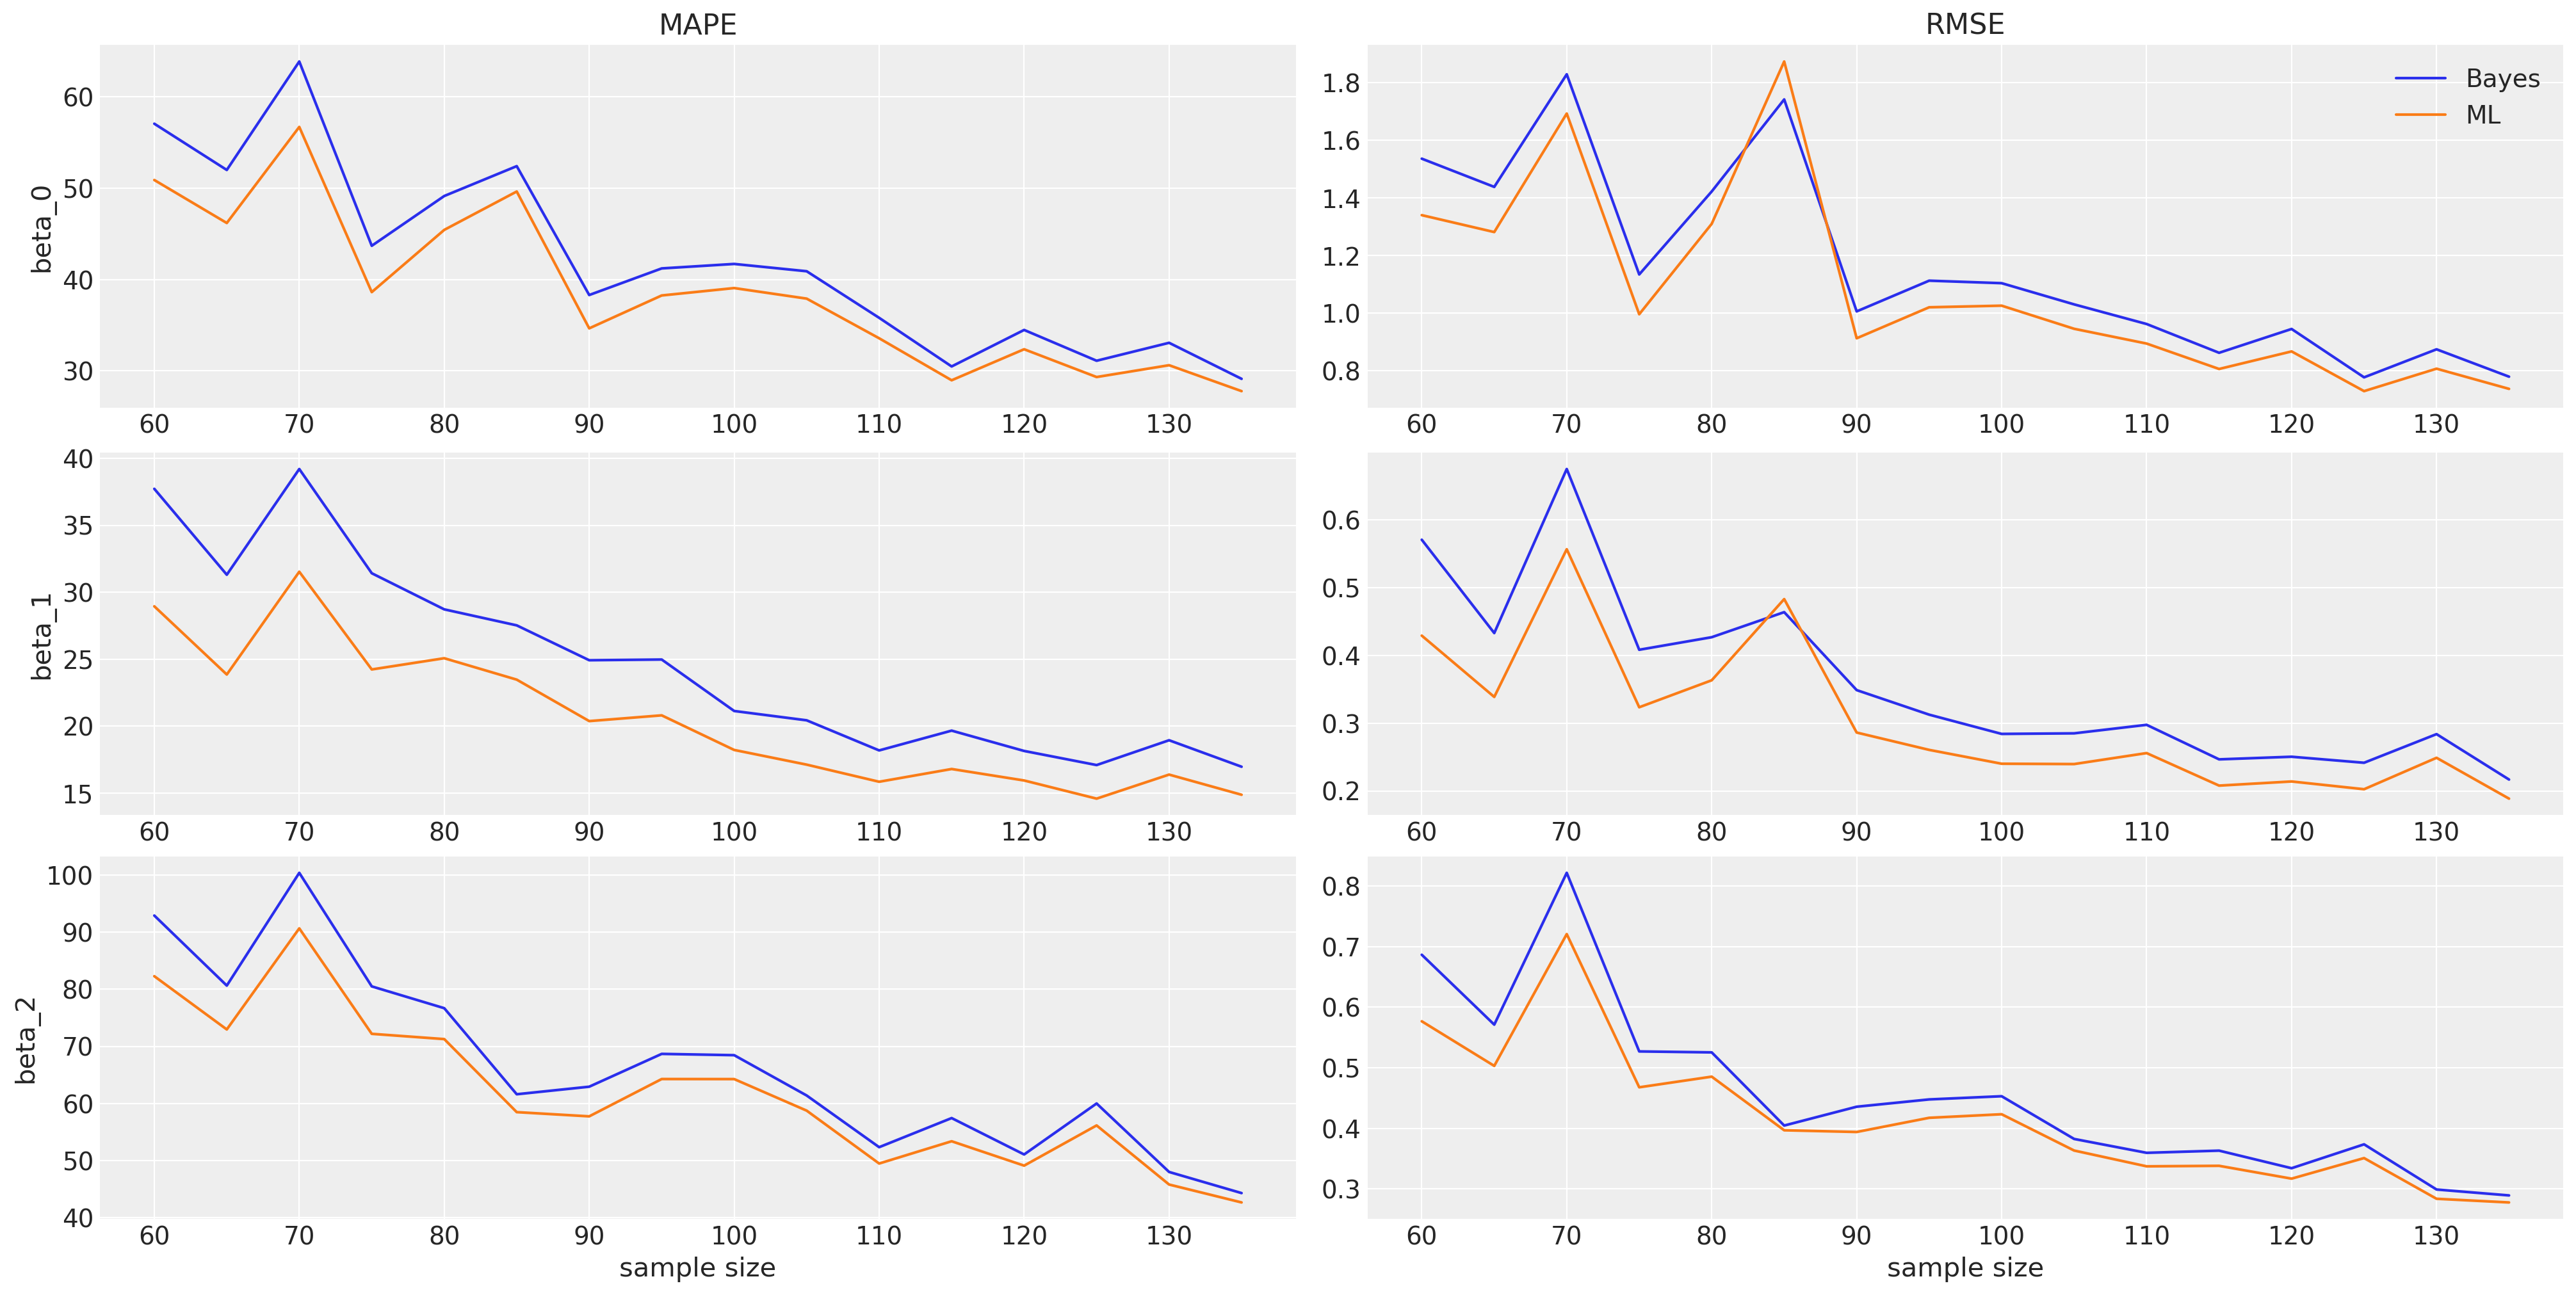

In [194]:
import matplotlib.pyplot as plt 


fig, axs = plt.subplots(3, 2, figsize=(20, 10))
axs[0, 0].plot(np.arange(60, 136, 5), all_metrics['bayes']['beta0'][0], label='Bayes')
axs[0, 0].plot(np.arange(60, 136, 5), all_metrics['ml']['beta0'][0], label='ML')
axs[0, 0].set_title('MAPE')
axs[0, 0].set(ylabel='beta_0')
axs[0, 1].plot(np.arange(60, 136, 5), all_metrics['bayes']['beta0'][1], label='Bayes')
axs[0, 1].plot(np.arange(60, 136, 5), all_metrics['ml']['beta0'][1], label='ML')
axs[0, 1].set_title('RMSE')
axs[0, 1].legend(loc="upper right")

axs[1, 0].plot(np.arange(60, 136, 5), all_metrics['bayes']['beta1'][0], label='Bayes')
axs[1, 0].plot(np.arange(60, 136, 5), all_metrics['ml']['beta1'][0], label='ML')

axs[1, 0].set(ylabel='beta_1')
axs[1, 1].plot(np.arange(60, 136, 5), all_metrics['bayes']['beta1'][1], label='Bayes')
axs[1, 1].plot(np.arange(60, 136, 5), all_metrics['ml']['beta1'][1], label='ML')


axs[2, 0].plot(np.arange(60, 136, 5), all_metrics['bayes']['beta2'][0], label='Bayes')
axs[2, 0].plot(np.arange(60, 136, 5), all_metrics['ml']['beta2'][0], label='ML')

axs[2, 0].set(ylabel='beta_2')
axs[2, 1].plot(np.arange(60, 136, 5), all_metrics['bayes']['beta2'][1], label='Bayes')
axs[2, 1].plot(np.arange(60, 136, 5), all_metrics['ml']['beta2'][1], label='ML')
axs[2, 0].set(xlabel='sample size')
axs[2, 1].set(xlabel='sample size')
plt.savefig('versus.pdf');

# Смесь

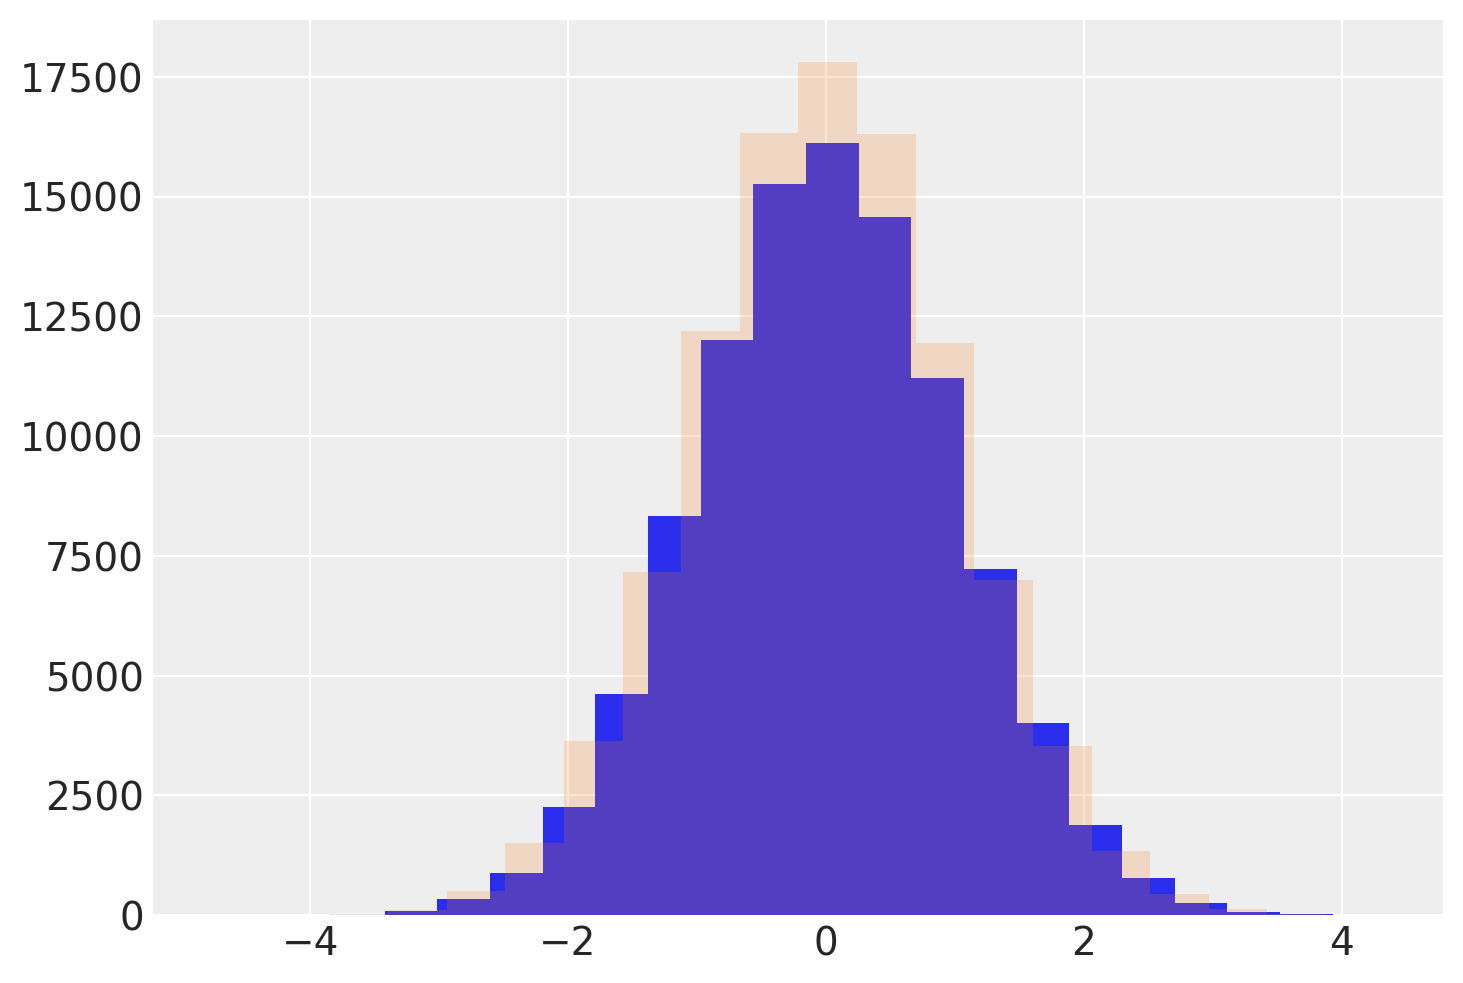

In [219]:
example = 1/3 * np.random.normal(3, 1, size=100000) + 2/3 * np.random.normal(-3/2, np.sqrt(3), size=100000)
norm_example = example / np.sqrt((1/9 + 4/3))

plt.hist(norm_example, bins=20)
plt.hist(np.random.normal(0, 1, size=100000), alpha=0.2, bins=20);

In [207]:
np.mean(norm_example), np.var(norm_example)

(-0.005078868942272187, 0.9941078731993266)

In [210]:
def generate_bad_sample(size=1000):
    x_0 = np.ones(shape=size)
    x_1 = np.random.normal(loc=3, scale=2, size=size)
    x_2 = np.random.uniform(low=1, high=3, size=size)
    X = np.vstack((x_0, x_1, x_2)).T
    
    betas = np.array([2, -1, 0.5])
    eps = 1/3 * np.random.normal(3, 1, size=size) + 2/3 * np.random.normal(-3/2, np.sqrt(3), size=size)
    norm_eps = eps / np.sqrt((1/9 + 4/3))

    y = (X @ betas + norm_eps > 0) * 1

    probit_data = {'n': size,
                   'y': y,
                   'x_1': x_1,
                   'x_2': x_2
                  }
    
    return probit_data

print('Доля единиц в целевой переменной:', np.mean(generate_bad_sample()['y']))

Доля единиц в целевой переменной: 0.491


In [211]:
params = ['beta0', 'beta1', 'beta2']
true_betas = [2, -1, 0.5]

def get_bad_results(size, n_epochs=100):
    
    results_bayes = {'beta0': [],
                     'beta1': [],
                     'beta2': []
                    }
    results_ml = {'beta0': [],
                  'beta1': [],
                  'beta2': []
                  }
    
    total_bayes = []
    total_ml = []
    
    for epoch in range(n_epochs):
        print('Размер выборки:', size, '------ Эпоха', epoch + 1, 'из', n_epochs)
        
        data_new = generate_bad_sample(size)
        
        # bayes
        coefs_bayes = get_estimates(data_new)
        for param in range(len(params)):
            results_bayes[params[param]].append(coefs_bayes[param])
            
        # maximum likelihood
        target = data_new['y']
        X_probit = np.vstack((np.ones(size), data_new['x_1'], data_new['x_2'])).T
        coefs_ml = Probit(target, X_probit).fit()
        for param in range(len(params)):
            results_ml[params[param]].append(coefs_ml.params[param])
        clear_output(wait=True)
        
    # подсчитываем метрики
    for i in range(len(params)):
        true_coef = np.ones(shape=n_epochs) * true_betas[i]
        total_bayes.append([params[i], 
                      mape(true_coef, results_bayes[params[i]]) * 100, # в процентах
                      mse(true_coef, results_bayes[params[i]], squared=False)])
        total_ml.append([params[i], 
                      mape(true_coef, results_ml[params[i]]) * 100, # в процентах
                      mse(true_coef, results_ml[params[i]], squared=False)])

    return total_bayes, total_ml


In [213]:
np.random.seed(999)

bad_res = get_bad_results(1000, n_epochs=100)

Размер выборки: 1000 ------ Эпоха 100 из 100


Sequential sampling (1 chains in 1 job)
NUTS: [beta2, beta1, beta0]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 6 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Optimization terminated successfully.
         Current function value: 0.324914
         Iterations 7


### Нормированная смесь + 1000 наблюдений

In [217]:
import pandas as pd

# Bayes
pd.DataFrame(bad_res[0], columns=['coef', 'MAPE', 'RMSE'])

,coef,MAPE,RMSE
0,beta0,10.532484,0.263074
1,beta1,4.662239,0.062988
2,beta2,15.982598,0.100883


In [218]:
# ML
pd.DataFrame(bad_res[1], columns=['coef', 'MAPE', 'RMSE'])

,coef,MAPE,RMSE
0,beta0,10.476201,0.261761
1,beta1,4.596422,0.062389
2,beta2,15.853640,0.100079


Малая выборка:

In [221]:
np.random.seed(999)

bad_res = get_bad_results(60, n_epochs=100)

Размер выборки: 60 ------ Эпоха 100 из 100


Sequential sampling (1 chains in 1 job)
NUTS: [beta2, beta1, beta0]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 4 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Optimization terminated successfully.
         Current function value: 0.339964
         Iterations 7


### Нормированная смесь + 60 наблюдений

In [222]:
# Bayes
pd.DataFrame(bad_res[0], columns=['coef', 'MAPE', 'RMSE'])

,coef,MAPE,RMSE
0,beta0,60.994480,1.879312
1,beta1,37.475186,0.577594
2,beta2,85.616157,0.542826


In [223]:
# ML
pd.DataFrame(bad_res[1], columns=['coef', 'MAPE', 'RMSE'])

,coef,MAPE,RMSE
0,beta0,56.074463,1.801654
1,beta1,29.868660,0.514914
2,beta2,75.475901,0.471853


# Ненормированная смесь

In [224]:
def generate_very_bad_sample(size=1000):
    x_0 = np.ones(shape=size)
    x_1 = np.random.normal(loc=3, scale=2, size=size)
    x_2 = np.random.uniform(low=1, high=3, size=size)
    X = np.vstack((x_0, x_1, x_2)).T
    
    betas = np.array([2, -1, 0.5])
    eps = 1/3 * np.random.normal(3, 1, size=size) + 2/3 * np.random.normal(-3/2, np.sqrt(3), size=size)

    y = (X @ betas + eps > 0) * 1

    probit_data = {'n': size,
                   'y': y,
                   'x_1': x_1,
                   'x_2': x_2
                  }
    
    return probit_data

print('Доля единиц в целевой переменной:', np.mean(generate_bad_sample()['y']))

Доля единиц в целевой переменной: 0.49


In [225]:
params = ['beta0', 'beta1', 'beta2']
true_betas = [2, -1, 0.5]

def get_very_bad_results(size, n_epochs=100):
    
    results_bayes = {'beta0': [],
                     'beta1': [],
                     'beta2': []
                    }
    results_ml = {'beta0': [],
                  'beta1': [],
                  'beta2': []
                  }
    
    total_bayes = []
    total_ml = []
    
    for epoch in range(n_epochs):
        print('Размер выборки:', size, '------ Эпоха', epoch + 1, 'из', n_epochs)
        
        data_new = generate_very_bad_sample(size)
        
        # bayes
        coefs_bayes = get_estimates(data_new)
        for param in range(len(params)):
            results_bayes[params[param]].append(coefs_bayes[param])
            
        # maximum likelihood
        target = data_new['y']
        X_probit = np.vstack((np.ones(size), data_new['x_1'], data_new['x_2'])).T
        coefs_ml = Probit(target, X_probit).fit()
        for param in range(len(params)):
            results_ml[params[param]].append(coefs_ml.params[param])
        clear_output(wait=True)
        
    # подсчитываем метрики
    for i in range(len(params)):
        true_coef = np.ones(shape=n_epochs) * true_betas[i]
        total_bayes.append([params[i], 
                      mape(true_coef, results_bayes[params[i]]) * 100, # в процентах
                      mse(true_coef, results_bayes[params[i]], squared=False)])
        total_ml.append([params[i], 
                      mape(true_coef, results_ml[params[i]]) * 100, # в процентах
                      mse(true_coef, results_ml[params[i]], squared=False)])

    return total_bayes, total_ml

In [230]:
np.random.seed(999)
 
badbadres = get_very_bad_results(1000)

Размер выборки: 1000 ------ Эпоха 100 из 100


Sequential sampling (1 chains in 1 job)
NUTS: [beta2, beta1, beta0]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Optimization terminated successfully.
         Current function value: 0.358632
         Iterations 7


### Ошибка из смеси нормальных (с дисперсией не 1) + 1000 наблюдений

In [231]:
# Bayes
pd.DataFrame(badbadres[0], columns=['coef', 'MAPE', 'RMSE'])

,coef,MAPE,RMSE
0,beta0,17.192823,0.392259
1,beta1,16.228391,0.167818
2,beta2,18.878970,0.111781


In [232]:
# ML
pd.DataFrame(badbadres[1], columns=['coef', 'MAPE', 'RMSE'])

,coef,MAPE,RMSE
0,beta0,17.509520,0.398024
1,beta1,16.611112,0.171453
2,beta2,19.084745,0.112902


In [227]:
np.random.seed(999)

badbadres = get_very_bad_results(60)

Размер выборки: 60 ------ Эпоха 100 из 100


Sequential sampling (1 chains in 1 job)
NUTS: [beta2, beta1, beta0]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 5 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Optimization terminated successfully.
         Current function value: 0.190375
         Iterations 9


### Ошибка из смеси нормальных (с дисперсией не 1) + 60 наблюдений

In [228]:
# Bayes
pd.DataFrame(badbadres[0], columns=['coef', 'MAPE', 'RMSE'])

,coef,MAPE,RMSE
0,beta0,49.390887,1.293955
1,beta1,23.827842,0.344658
2,beta2,75.918862,0.503926


In [229]:
# ML
pd.DataFrame(badbadres[1], columns=['coef', 'MAPE', 'RMSE'])

,coef,MAPE,RMSE
0,beta0,46.307130,1.177321
1,beta1,21.867879,0.296427
2,beta2,71.604182,0.464364


In [240]:
def generate_logit_sample(size=1000):
    x_0 = np.ones(shape=size)
    x_1 = np.random.normal(loc=3, scale=2, size=size)
    x_2 = np.random.uniform(low=1, high=3, size=size)
    X = np.vstack((x_0, x_1, x_2)).T
    
    betas = np.array([2, -1, 0.5])
    eps = np.random.logistic(0, 1, size=size)

    y = (X @ betas + eps > 0) * 1

    probit_data = {'n': size,
                   'y': y,
                   'x_1': x_1,
                   'x_2': x_2
                  }
    
    return probit_data

print('Доля единиц в целевой переменной:', np.mean(generate_logit_sample()['y']))

Доля единиц в целевой переменной: 0.524


In [239]:
params = ['beta0', 'beta1', 'beta2']
true_betas = [2, -1, 0.5]

def get_logit_results(size, n_epochs=100):
    
    results_bayes = {'beta0': [],
                     'beta1': [],
                     'beta2': []
                    }
    results_ml = {'beta0': [],
                  'beta1': [],
                  'beta2': []
                  }
    
    total_bayes = []
    total_ml = []
    
    for epoch in range(n_epochs):
        print('Размер выборки:', size, '------ Эпоха', epoch + 1, 'из', n_epochs)
        
        data_new = generate_logit_sample(size)
        
        # bayes
        coefs_bayes = get_estimates(data_new)
        for param in range(len(params)):
            results_bayes[params[param]].append(coefs_bayes[param])
            
        # maximum likelihood
        target = data_new['y']
        X_probit = np.vstack((np.ones(size), data_new['x_1'], data_new['x_2'])).T
        coefs_ml = Probit(target, X_probit).fit()
        for param in range(len(params)):
            results_ml[params[param]].append(coefs_ml.params[param])
        clear_output(wait=True)
        
    # подсчитываем метрики
    for i in range(len(params)):
        true_coef = np.ones(shape=n_epochs) * true_betas[i]
        total_bayes.append([params[i], 
                      mape(true_coef, results_bayes[params[i]]) * 100, # в процентах
                      mse(true_coef, results_bayes[params[i]], squared=False)])
        total_ml.append([params[i], 
                      mape(true_coef, results_ml[params[i]]) * 100, # в процентах
                      mse(true_coef, results_ml[params[i]], squared=False)])

    return total_bayes, total_ml

In [241]:
np.random.seed(999)

badbadres = get_logit_results(1000)

Размер выборки: 1000 ------ Эпоха 100 из 100


Sequential sampling (1 chains in 1 job)
NUTS: [beta2, beta1, beta0]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Optimization terminated successfully.
         Current function value: 0.421161
         Iterations 6


### Логистическая ошибка + 1000 наблюдений

In [242]:
# Bayes
pd.DataFrame(badbadres[0], columns=['coef', 'MAPE', 'RMSE'])

,coef,MAPE,RMSE
0,beta0,39.587295,0.815078
1,beta1,41.341694,0.414983
2,beta2,44.072669,0.233927


In [243]:
# ML
pd.DataFrame(badbadres[1], columns=['coef', 'MAPE', 'RMSE'])

,coef,MAPE,RMSE
0,beta0,39.804741,0.819366
1,beta1,41.543926,0.416991
2,beta2,44.251826,0.234743


## Разные априорные

### Случай провидцев (априорное оч угадывательное)

In [246]:
def get_exact_estimates(data, est=np.mean):

    with pm.Model() as model:

        beta0 = pm.Normal('beta0', mu=2, sigma=1)
        beta1 = pm.Normal('beta1', mu=-1, sigma=1)
        beta2 = pm.Normal('beta2', mu=0.5, sigma=1)
    
        z = beta0 + beta1 * data['x_1'] + beta2 * data['x_2']
        probs = probit_phi(z)

        y = pm.Bernoulli('y', p=probs, observed=data['y'])
    
        step = pm.NUTS()
        trace = pm.sample(2000, chains=1, cores=-1, step=step, progressbar=True)
        # az.plot_trace(trace)
        return est(trace.get_values('beta0')), est(trace.get_values('beta1')), est(trace.get_values('beta2'))

In [251]:
params = ['beta0', 'beta1', 'beta2']
true_betas = [2, -1, 0.5]

def get_exact_results(size, n_epochs=100):
    
    results_bayes = {'beta0': [],
                     'beta1': [],
                     'beta2': []
                    }
    results_ml = {'beta0': [],
                  'beta1': [],
                  'beta2': []
                  }
    
    total_bayes = []
    total_ml = []
    
    for epoch in range(n_epochs):
        print('Размер выборки:', size, '------ Эпоха', epoch + 1, 'из', n_epochs)
        
        data_new = generate_sample(size)
        
        # bayes
        coefs_bayes = get_exact_estimates(data_new)
        for param in range(len(params)):
            results_bayes[params[param]].append(coefs_bayes[param])
            
        # maximum likelihood
        target = data_new['y']
        X_probit = np.vstack((np.ones(size), data_new['x_1'], data_new['x_2'])).T
        coefs_ml = Probit(target, X_probit).fit()
        for param in range(len(params)):
            results_ml[params[param]].append(coefs_ml.params[param])
        clear_output(wait=True)
        
    # подсчитываем метрики
    
    for i in range(len(params)):
        true_coef = np.ones(shape=n_epochs) * true_betas[i]
        total_bayes.append([params[i], 
                      mape(true_coef, results_bayes[params[i]]) * 100, # в процентах
                      mse(true_coef, results_bayes[params[i]], squared=False)])
        total_ml.append([params[i], 
                      mape(true_coef, results_ml[params[i]]) * 100, # в процентах
                      mse(true_coef, results_ml[params[i]], squared=False)])

    return total_bayes, total_ml



In [250]:
get_exact_results(60, n_epochs=2)

(    coef        MAPE      RMSE
 0  beta0   32.206774  0.707485
 1  beta1   26.786228  0.348410
 2  beta2  150.746561  0.890486,
     coef        MAPE      RMSE
 0  beta0   95.602737  2.331945
 1  beta1   47.939255  0.613891
 2  beta2  344.290434  2.137022)

In [252]:
np.random.seed(999)

all_metrics = {'bayes': {'beta0': [[], []],
                         'beta1': [[], []],
                         'beta2': [[], []]},
              'ml':     {'beta0': [[], []],
                         'beta1': [[], []],
                         'beta2': [[], []]}}

for sample_size in range(60, 301, 20):
    results = get_exact_results(sample_size)
    
    all_metrics['bayes']['beta0'][0].append(results[0][0][1])
    all_metrics['bayes']['beta0'][1].append(results[0][0][2])
    all_metrics['bayes']['beta1'][0].append(results[0][1][1])
    all_metrics['bayes']['beta1'][1].append(results[0][1][2])
    all_metrics['bayes']['beta2'][0].append(results[0][2][1])
    all_metrics['bayes']['beta2'][1].append(results[0][2][2])
    
    all_metrics['ml']['beta0'][0].append(results[1][0][1])
    all_metrics['ml']['beta0'][1].append(results[1][0][2])
    all_metrics['ml']['beta1'][0].append(results[1][1][1])
    all_metrics['ml']['beta1'][1].append(results[1][1][2])
    all_metrics['ml']['beta2'][0].append(results[1][2][1])
    all_metrics['ml']['beta2'][1].append(results[1][2][2])

Размер выборки: 300 ------ Эпоха 100 из 100


Sequential sampling (1 chains in 1 job)
NUTS: [beta2, beta1, beta0]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Optimization terminated successfully.
         Current function value: 0.342459
         Iterations 7


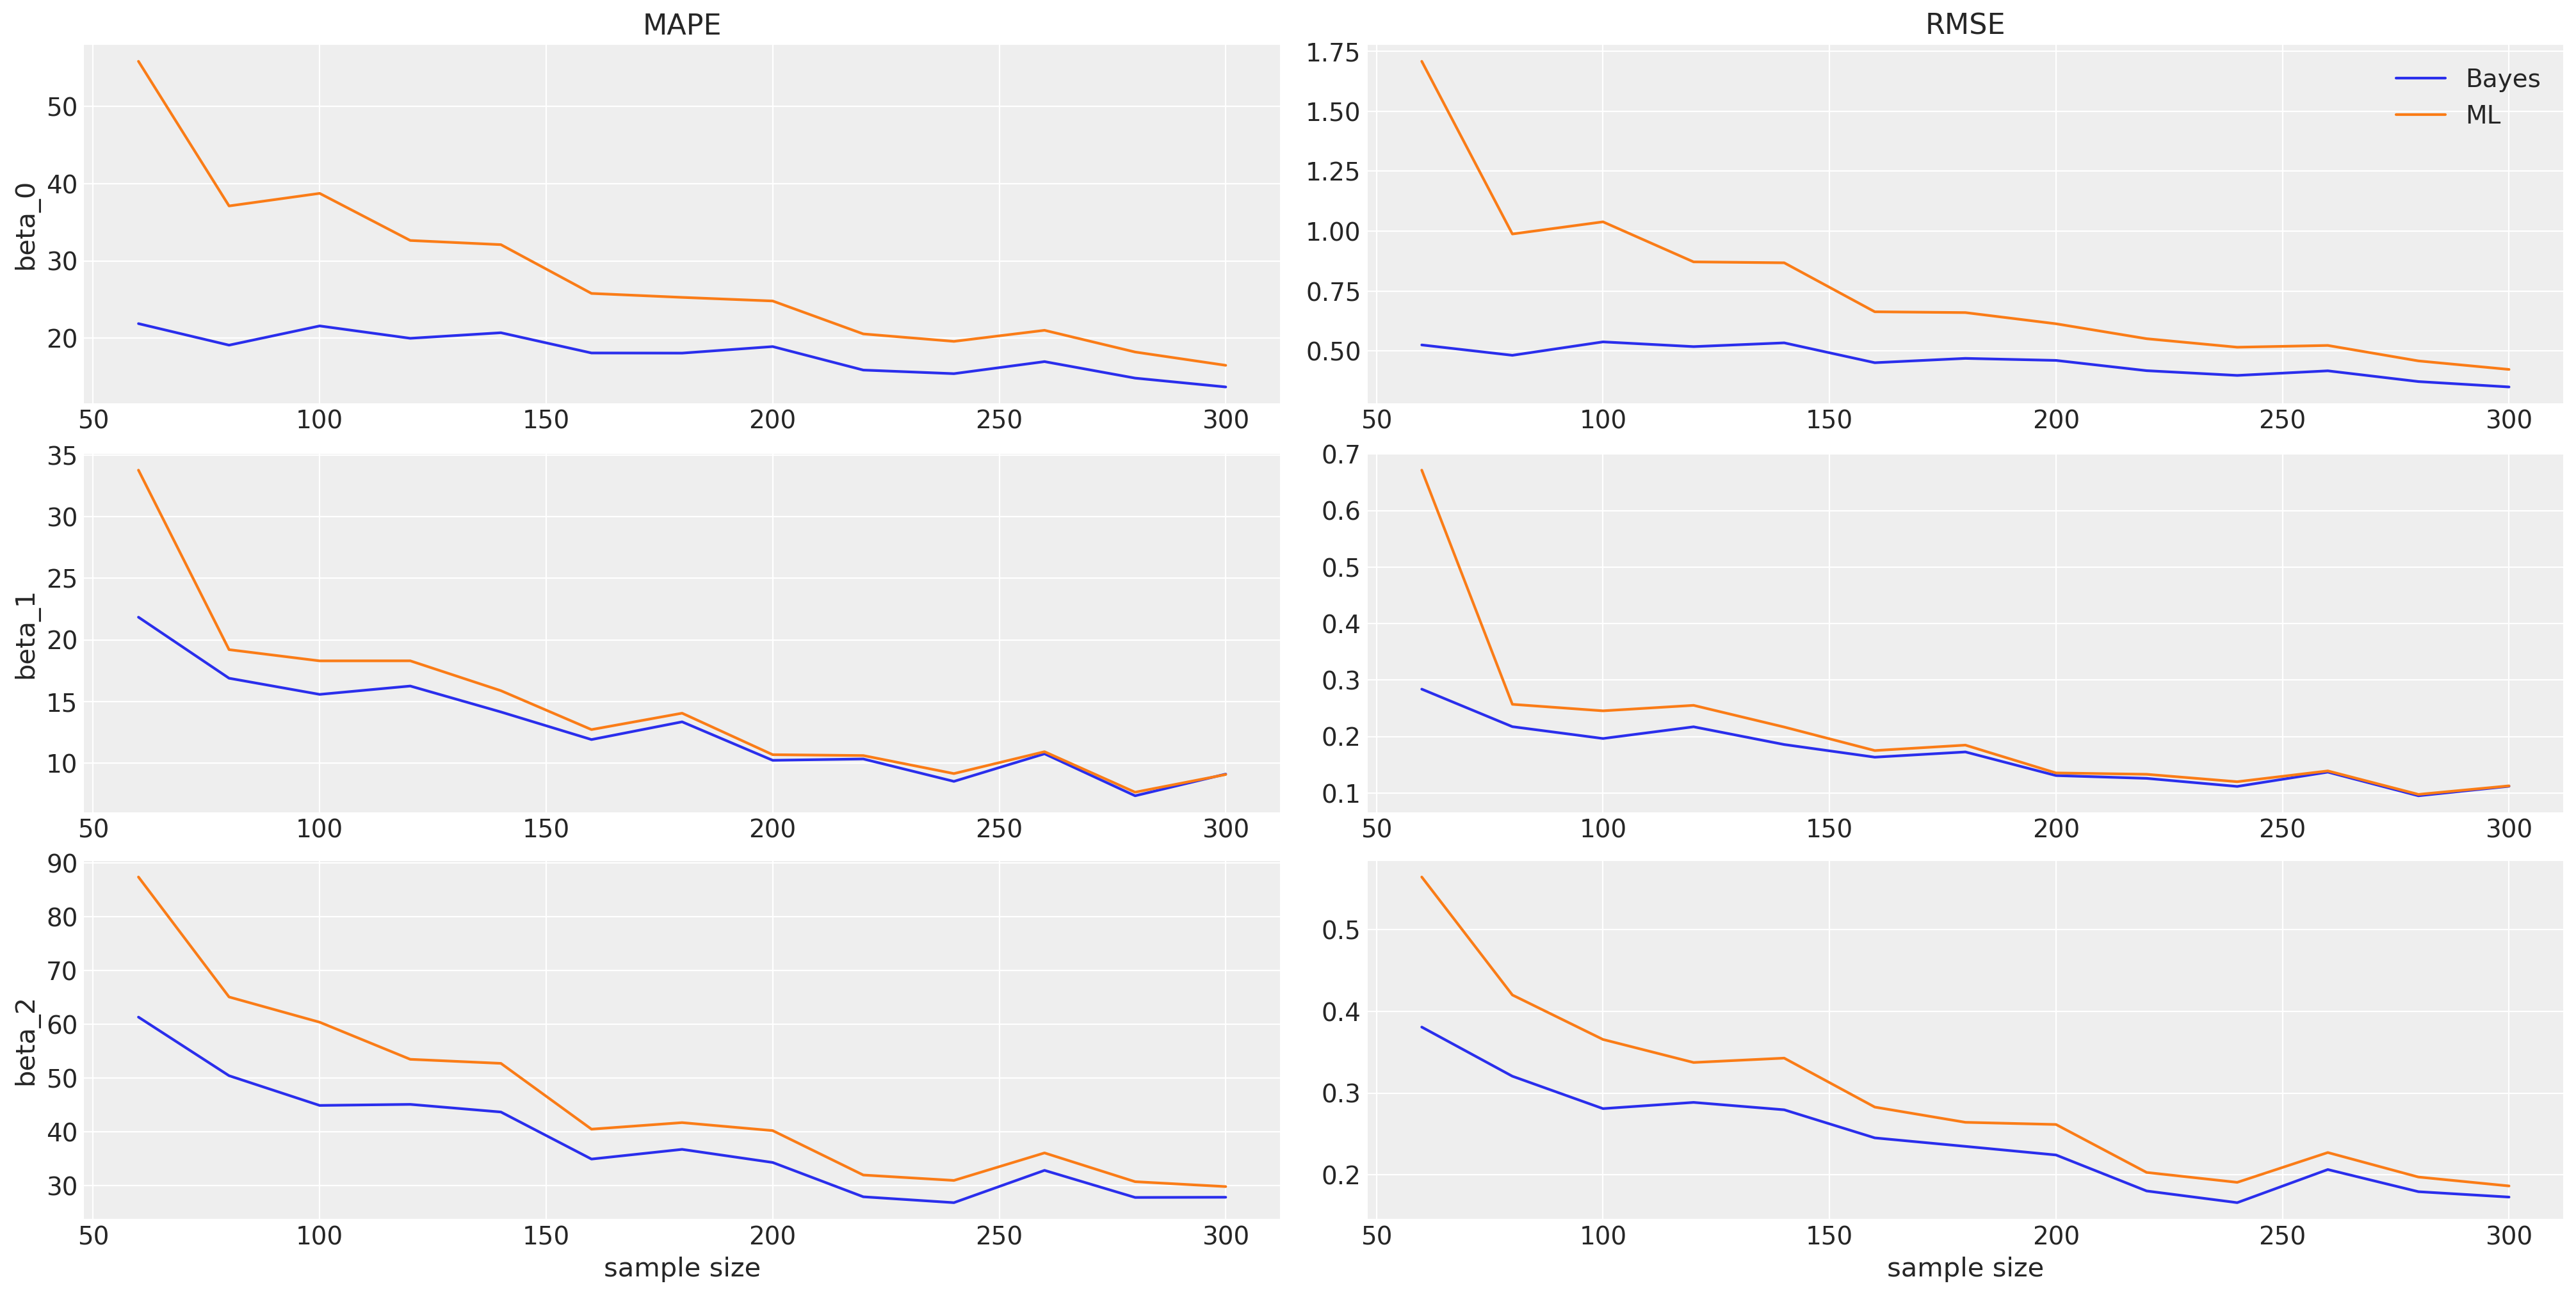

In [255]:
fig, axs = plt.subplots(3, 2, figsize=(20, 10))
axs[0, 0].plot(np.arange(60, 301, 20), all_metrics['bayes']['beta0'][0], label='Bayes')
axs[0, 0].plot(np.arange(60, 301, 20), all_metrics['ml']['beta0'][0], label='ML')
axs[0, 0].set_title('MAPE')
axs[0, 0].set(ylabel='beta_0')
axs[0, 1].plot(np.arange(60, 301, 20), all_metrics['bayes']['beta0'][1], label='Bayes')
axs[0, 1].plot(np.arange(60, 301, 20), all_metrics['ml']['beta0'][1], label='ML')
axs[0, 1].set_title('RMSE')
axs[0, 1].legend(loc="upper right")

axs[1, 0].plot(np.arange(60, 301, 20), all_metrics['bayes']['beta1'][0], label='Bayes')
axs[1, 0].plot(np.arange(60, 301, 20), all_metrics['ml']['beta1'][0], label='ML')

axs[1, 0].set(ylabel='beta_1')
axs[1, 1].plot(np.arange(60, 301, 20), all_metrics['bayes']['beta1'][1], label='Bayes')
axs[1, 1].plot(np.arange(60, 301, 20), all_metrics['ml']['beta1'][1], label='ML')


axs[2, 0].plot(np.arange(60, 301, 20), all_metrics['bayes']['beta2'][0], label='Bayes')
axs[2, 0].plot(np.arange(60, 301, 20), all_metrics['ml']['beta2'][0], label='ML')

axs[2, 0].set(ylabel='beta_2')
axs[2, 1].plot(np.arange(60, 301, 20), all_metrics['bayes']['beta2'][1], label='Bayes')
axs[2, 1].plot(np.arange(60, 301, 20), all_metrics['ml']['beta2'][1], label='ML')
axs[2, 0].set(xlabel='sample size')
axs[2, 1].set(xlabel='sample size')
plt.savefig('versus_good_prior.pdf');

Априорные $\mathcal{N}(\beta, 1)$

In [256]:
np.random.seed(999)

get_exact_results(1000)

([['beta0', 9.442862458264917, 0.2250212044689622],
  ['beta1', 4.649302665211062, 0.05811240226589941],
  ['beta2', 17.620739562463392, 0.10781345499504208]],
 [['beta0', 10.003825274498107, 0.23752694890087075],
  ['beta1', 4.691730134095185, 0.05875935850011475],
  ['beta2', 18.230710822975745, 0.11113340571772683]])

In [257]:
def get_semiexact_estimates(data, est=np.mean):

    with pm.Model() as model:

        beta0 = pm.Normal('beta0', mu=2, sigma=5)
        beta1 = pm.Normal('beta1', mu=-1, sigma=5)
        beta2 = pm.Normal('beta2', mu=0.5, sigma=5)
    
        z = beta0 + beta1 * data['x_1'] + beta2 * data['x_2']
        probs = probit_phi(z)

        y = pm.Bernoulli('y', p=probs, observed=data['y'])
    
        step = pm.NUTS()
        trace = pm.sample(2000, chains=1, cores=-1, step=step, progressbar=True)
        # az.plot_trace(trace)
        return est(trace.get_values('beta0')), est(trace.get_values('beta1')), est(trace.get_values('beta2'))

In [258]:
params = ['beta0', 'beta1', 'beta2']
true_betas = [2, -1, 0.5]

def get_semiexact_results(size, n_epochs=100):
    
    results_bayes = {'beta0': [],
                     'beta1': [],
                     'beta2': []
                    }
    results_ml = {'beta0': [],
                  'beta1': [],
                  'beta2': []
                  }
    
    total_bayes = []
    total_ml = []
    
    for epoch in range(n_epochs):
        print('Размер выборки:', size, '------ Эпоха', epoch + 1, 'из', n_epochs)
        
        data_new = generate_sample(size)
        
        # bayes
        coefs_bayes = get_semiexact_estimates(data_new)
        for param in range(len(params)):
            results_bayes[params[param]].append(coefs_bayes[param])
            
        # maximum likelihood
        target = data_new['y']
        X_probit = np.vstack((np.ones(size), data_new['x_1'], data_new['x_2'])).T
        coefs_ml = Probit(target, X_probit).fit()
        for param in range(len(params)):
            results_ml[params[param]].append(coefs_ml.params[param])
        clear_output(wait=True)
        
    # подсчитываем метрики
    
    for i in range(len(params)):
        true_coef = np.ones(shape=n_epochs) * true_betas[i]
        total_bayes.append([params[i], 
                      mape(true_coef, results_bayes[params[i]]) * 100, # в процентах
                      mse(true_coef, results_bayes[params[i]], squared=False)])
        total_ml.append([params[i], 
                      mape(true_coef, results_ml[params[i]]) * 100, # в процентах
                      mse(true_coef, results_ml[params[i]], squared=False)])

    return total_bayes, total_ml




In [260]:
np.random.seed(999)

all_metrics = {'bayes': {'beta0': [[], []],
                         'beta1': [[], []],
                         'beta2': [[], []]},
              'ml':     {'beta0': [[], []],
                         'beta1': [[], []],
                         'beta2': [[], []]}}

for sample_size in range(60, 301, 60):
    results = get_semiexact_results(sample_size)
    
    all_metrics['bayes']['beta0'][0].append(results[0][0][1])
    all_metrics['bayes']['beta0'][1].append(results[0][0][2])
    all_metrics['bayes']['beta1'][0].append(results[0][1][1])
    all_metrics['bayes']['beta1'][1].append(results[0][1][2])
    all_metrics['bayes']['beta2'][0].append(results[0][2][1])
    all_metrics['bayes']['beta2'][1].append(results[0][2][2])
    
    all_metrics['ml']['beta0'][0].append(results[1][0][1])
    all_metrics['ml']['beta0'][1].append(results[1][0][2])
    all_metrics['ml']['beta1'][0].append(results[1][1][1])
    all_metrics['ml']['beta1'][1].append(results[1][1][2])
    all_metrics['ml']['beta2'][0].append(results[1][2][1])
    all_metrics['ml']['beta2'][1].append(results[1][2][2])

Размер выборки: 300 ------ Эпоха 100 из 100


Sequential sampling (1 chains in 1 job)
NUTS: [beta2, beta1, beta0]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Optimization terminated successfully.
         Current function value: 0.346670
         Iterations 7


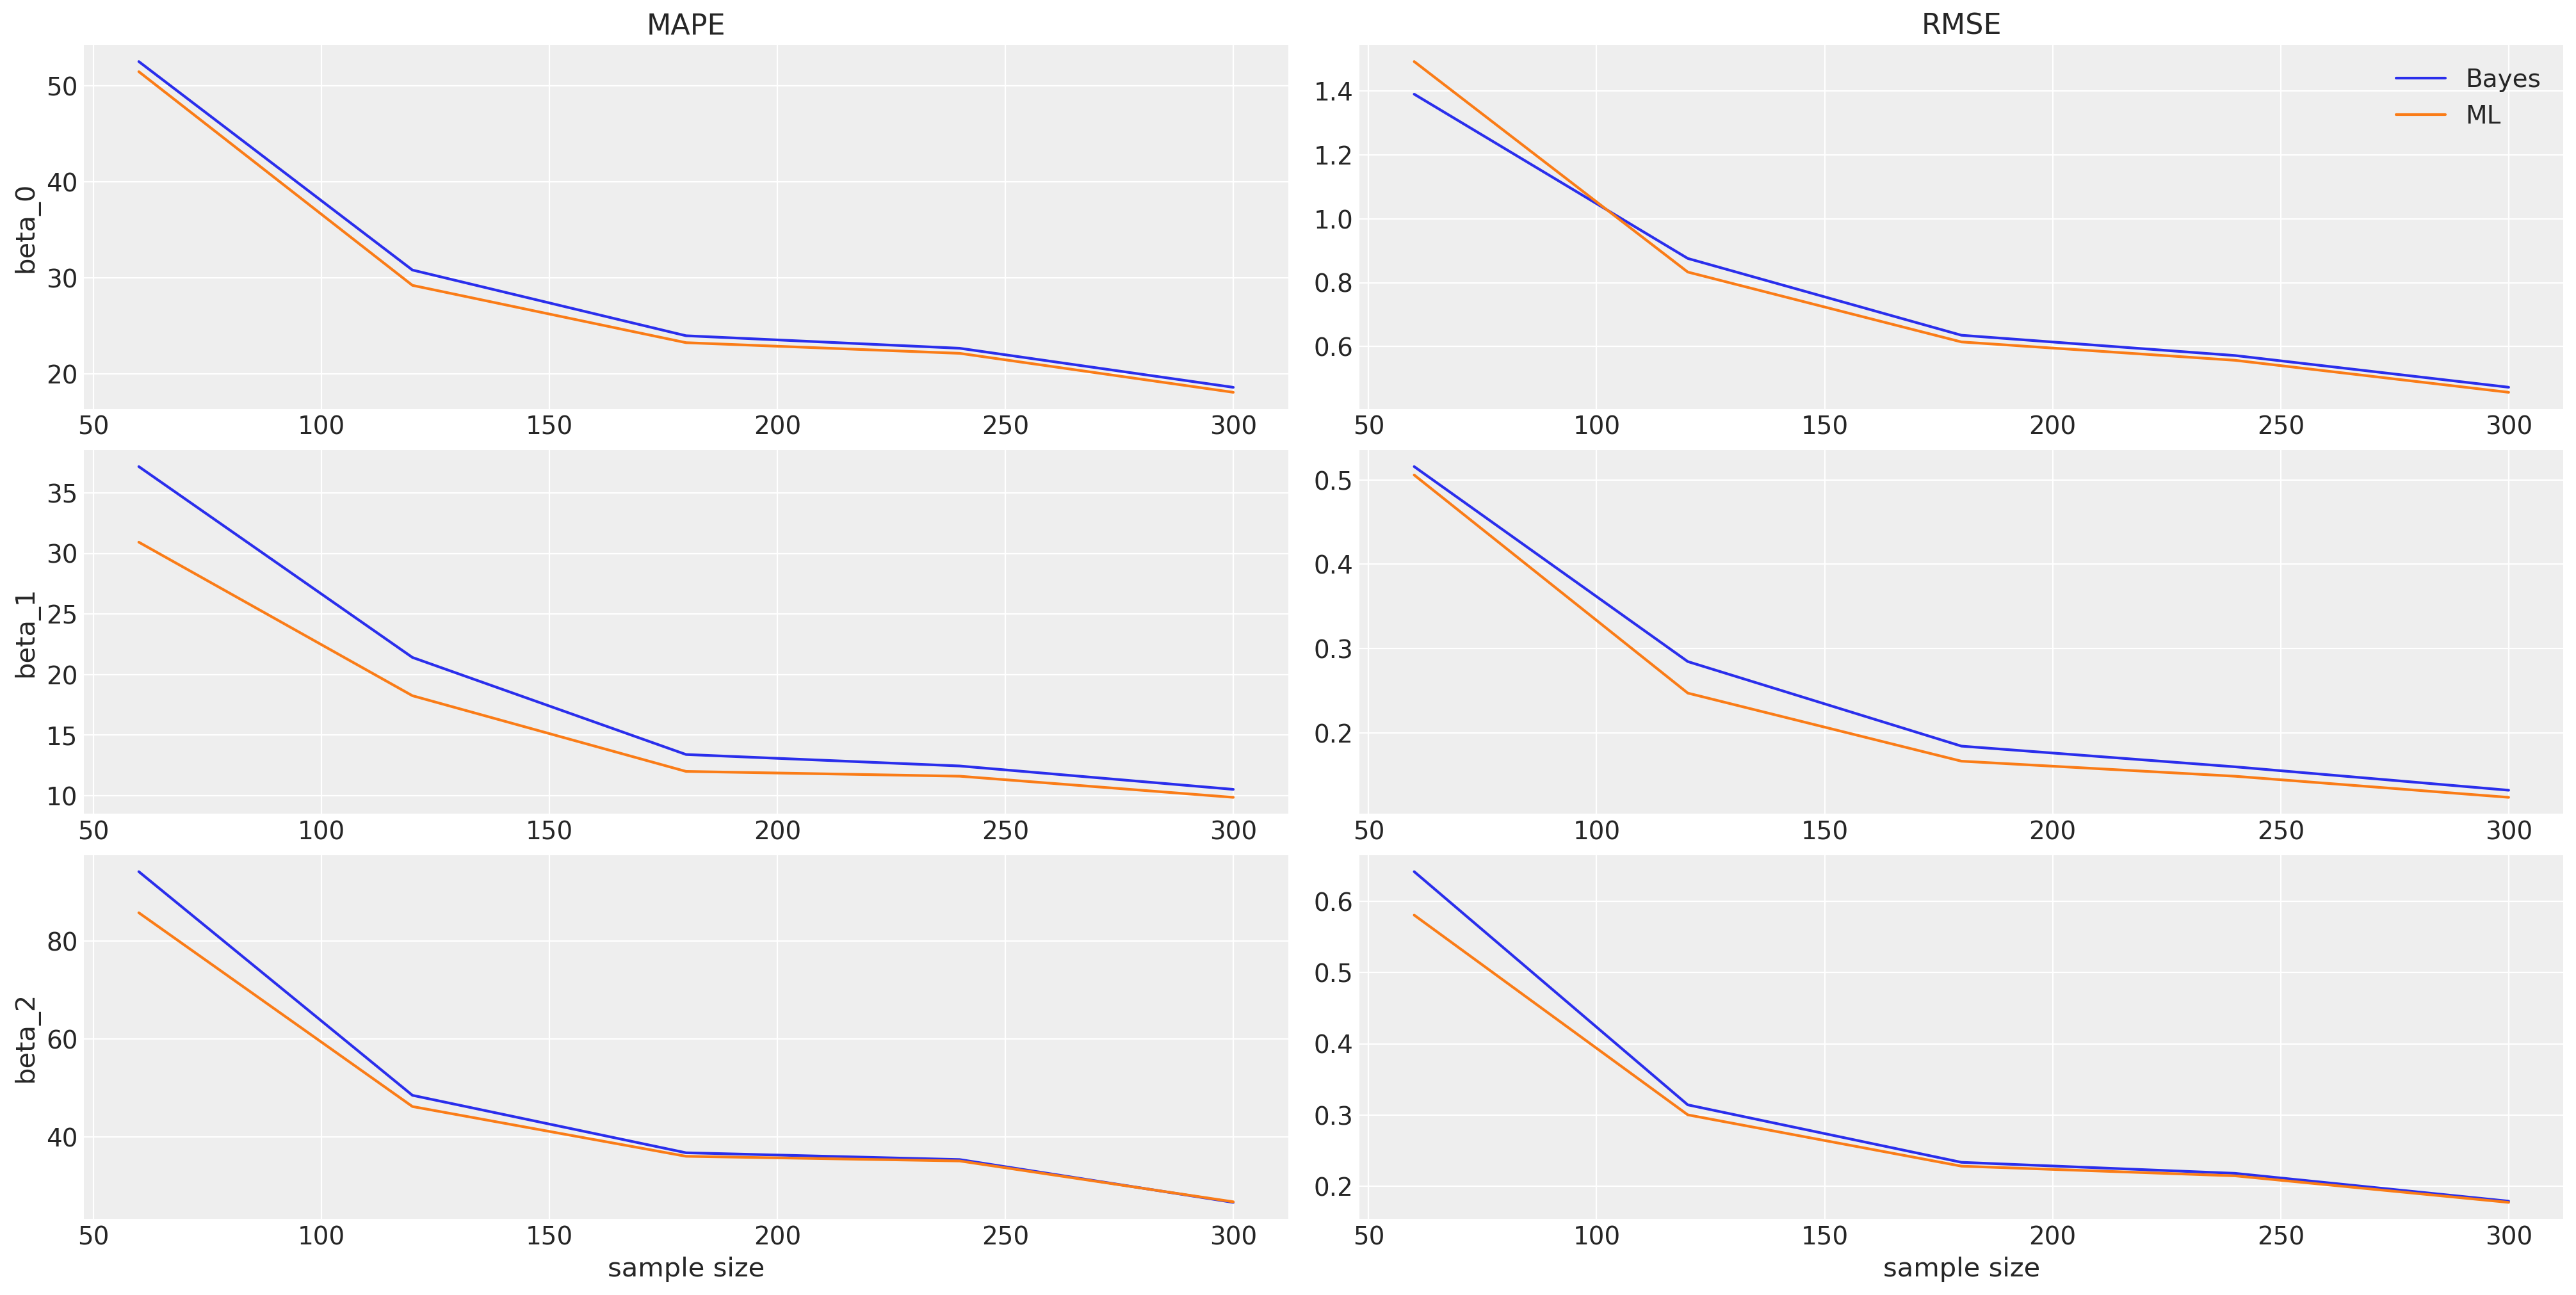

In [261]:
fig, axs = plt.subplots(3, 2, figsize=(20, 10))
axs[0, 0].plot(np.arange(60, 301, 60), all_metrics['bayes']['beta0'][0], label='Bayes')
axs[0, 0].plot(np.arange(60, 301, 60), all_metrics['ml']['beta0'][0], label='ML')
axs[0, 0].set_title('MAPE')
axs[0, 0].set(ylabel='beta_0')
axs[0, 1].plot(np.arange(60, 301, 60), all_metrics['bayes']['beta0'][1], label='Bayes')
axs[0, 1].plot(np.arange(60, 301, 60), all_metrics['ml']['beta0'][1], label='ML')
axs[0, 1].set_title('RMSE')
axs[0, 1].legend(loc="upper right")

axs[1, 0].plot(np.arange(60, 301, 60), all_metrics['bayes']['beta1'][0], label='Bayes')
axs[1, 0].plot(np.arange(60, 301, 60), all_metrics['ml']['beta1'][0], label='ML')

axs[1, 0].set(ylabel='beta_1')
axs[1, 1].plot(np.arange(60, 301, 60), all_metrics['bayes']['beta1'][1], label='Bayes')
axs[1, 1].plot(np.arange(60, 301, 60), all_metrics['ml']['beta1'][1], label='ML')


axs[2, 0].plot(np.arange(60, 301, 60), all_metrics['bayes']['beta2'][0], label='Bayes')
axs[2, 0].plot(np.arange(60, 301, 60), all_metrics['ml']['beta2'][0], label='ML')

axs[2, 0].set(ylabel='beta_2')
axs[2, 1].plot(np.arange(60, 301, 60), all_metrics['bayes']['beta2'][1], label='Bayes')
axs[2, 1].plot(np.arange(60, 301, 60), all_metrics['ml']['beta2'][1], label='ML')
axs[2, 0].set(xlabel='sample size')
axs[2, 1].set(xlabel='sample size')
plt.savefig('versus_semigood_prior.pdf');


Если стандартное нормальное

In [263]:
def get_strange_estimates(data, est=np.mean):

    with pm.Model() as model:

        beta0 = pm.Normal('beta0', mu=0, sigma=1)
        beta1 = pm.Normal('beta1', mu=0, sigma=1)
        beta2 = pm.Normal('beta2', mu=0, sigma=1)
    
        z = beta0 + beta1 * data['x_1'] + beta2 * data['x_2']
        probs = probit_phi(z)

        y = pm.Bernoulli('y', p=probs, observed=data['y'])
    
        step = pm.NUTS()
        trace = pm.sample(2000, chains=1, cores=-1, step=step, progressbar=True)
        # az.plot_trace(trace)
        return trace, est(trace.get_values('beta0')), est(trace.get_values('beta1')), est(trace.get_values('beta2'))

In [264]:

np.random.seed(999)

data1 = generate_sample(1000)
a, _, _, _ = get_strange_estimates(data1, est=np.mean)


Sequential sampling (1 chains in 1 job)
NUTS: [beta2, beta1, beta0]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


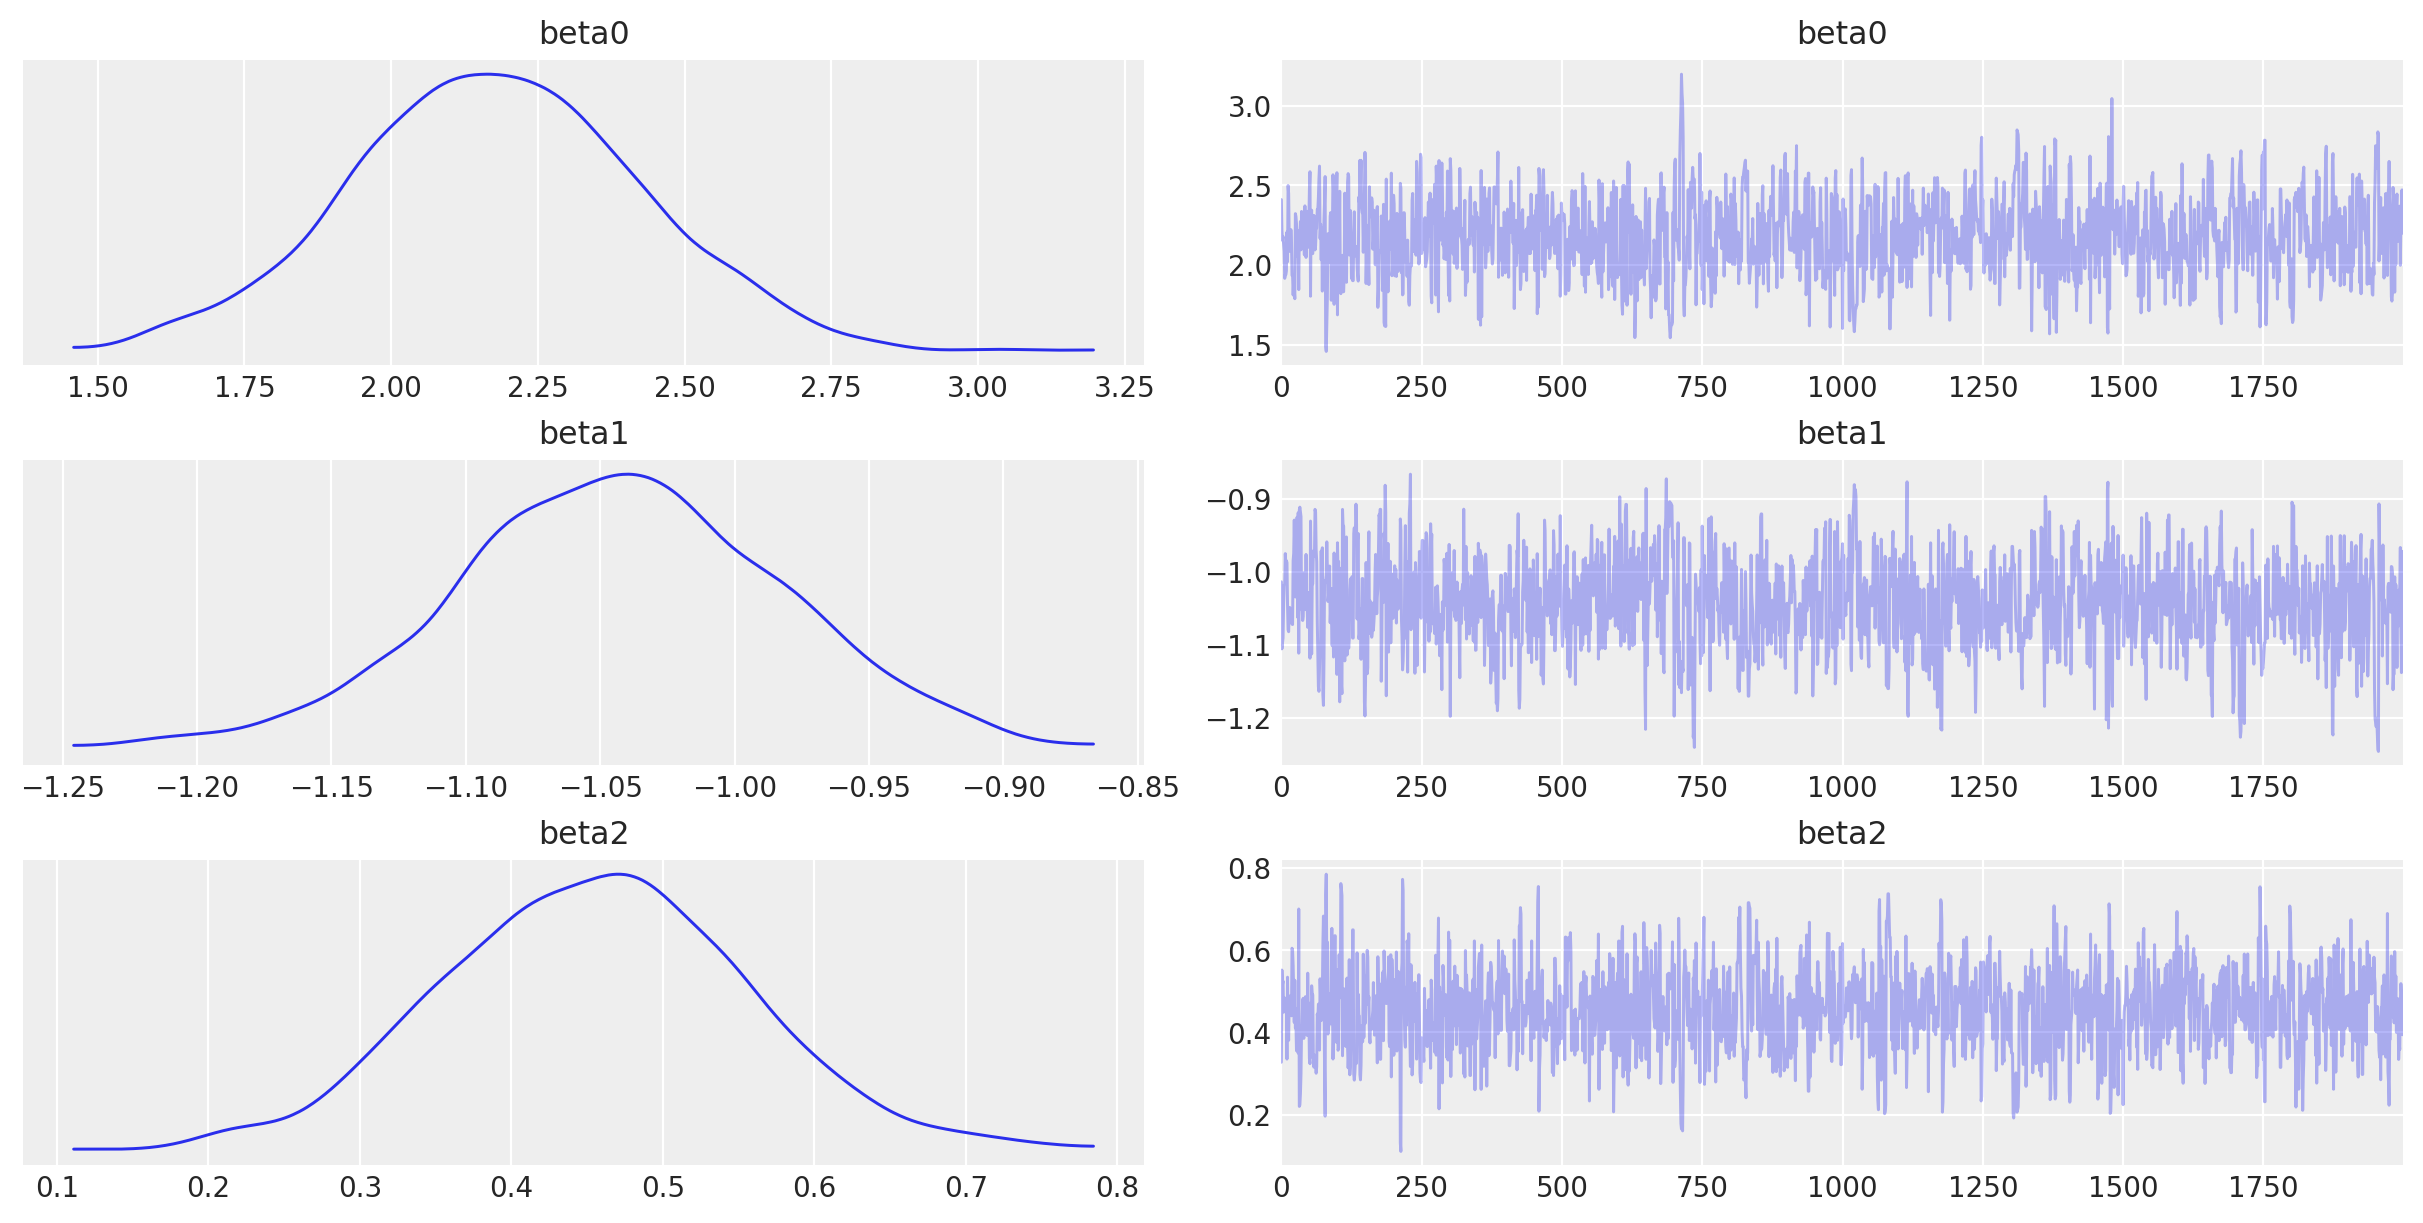

In [271]:
az.plot_trace(a);

In [301]:
def get_strange_estimates(data, est=np.mean):

    with pm.Model() as model:

        beta0 = pm.Normal('beta0', mu=0, sigma=3)
        beta1 = pm.Normal('beta1', mu=0, sigma=3)
        beta2 = pm.Normal('beta2', mu=0, sigma=3)
    
        z = beta0 + beta1 * data['x_1'] + beta2 * data['x_2']
        probs = probit_phi(z)

        y = pm.Bernoulli('y', p=probs, observed=data['y'])
    
        step = pm.NUTS()
        trace = pm.sample(2000, init='advi',
                          tune=1000, chains=1, cores=-1, step=step, progressbar=True)
        # az.plot_trace(trace)
        return est(trace.get_values('beta0')), est(trace.get_values('beta1')), est(trace.get_values('beta2'))

Sequential sampling (1 chains in 1 job)
NUTS: [beta2, beta1, beta0]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


CPU times: user 57.2 s, sys: 647 ms, total: 57.8 s
Wall time: 58 s


array([[<AxesSubplot:title={'center':'beta0'}>,
        <AxesSubplot:title={'center':'beta0'}>],
       [<AxesSubplot:title={'center':'beta1'}>,
        <AxesSubplot:title={'center':'beta1'}>],
       [<AxesSubplot:title={'center':'beta2'}>,
        <AxesSubplot:title={'center':'beta2'}>]], dtype=object)

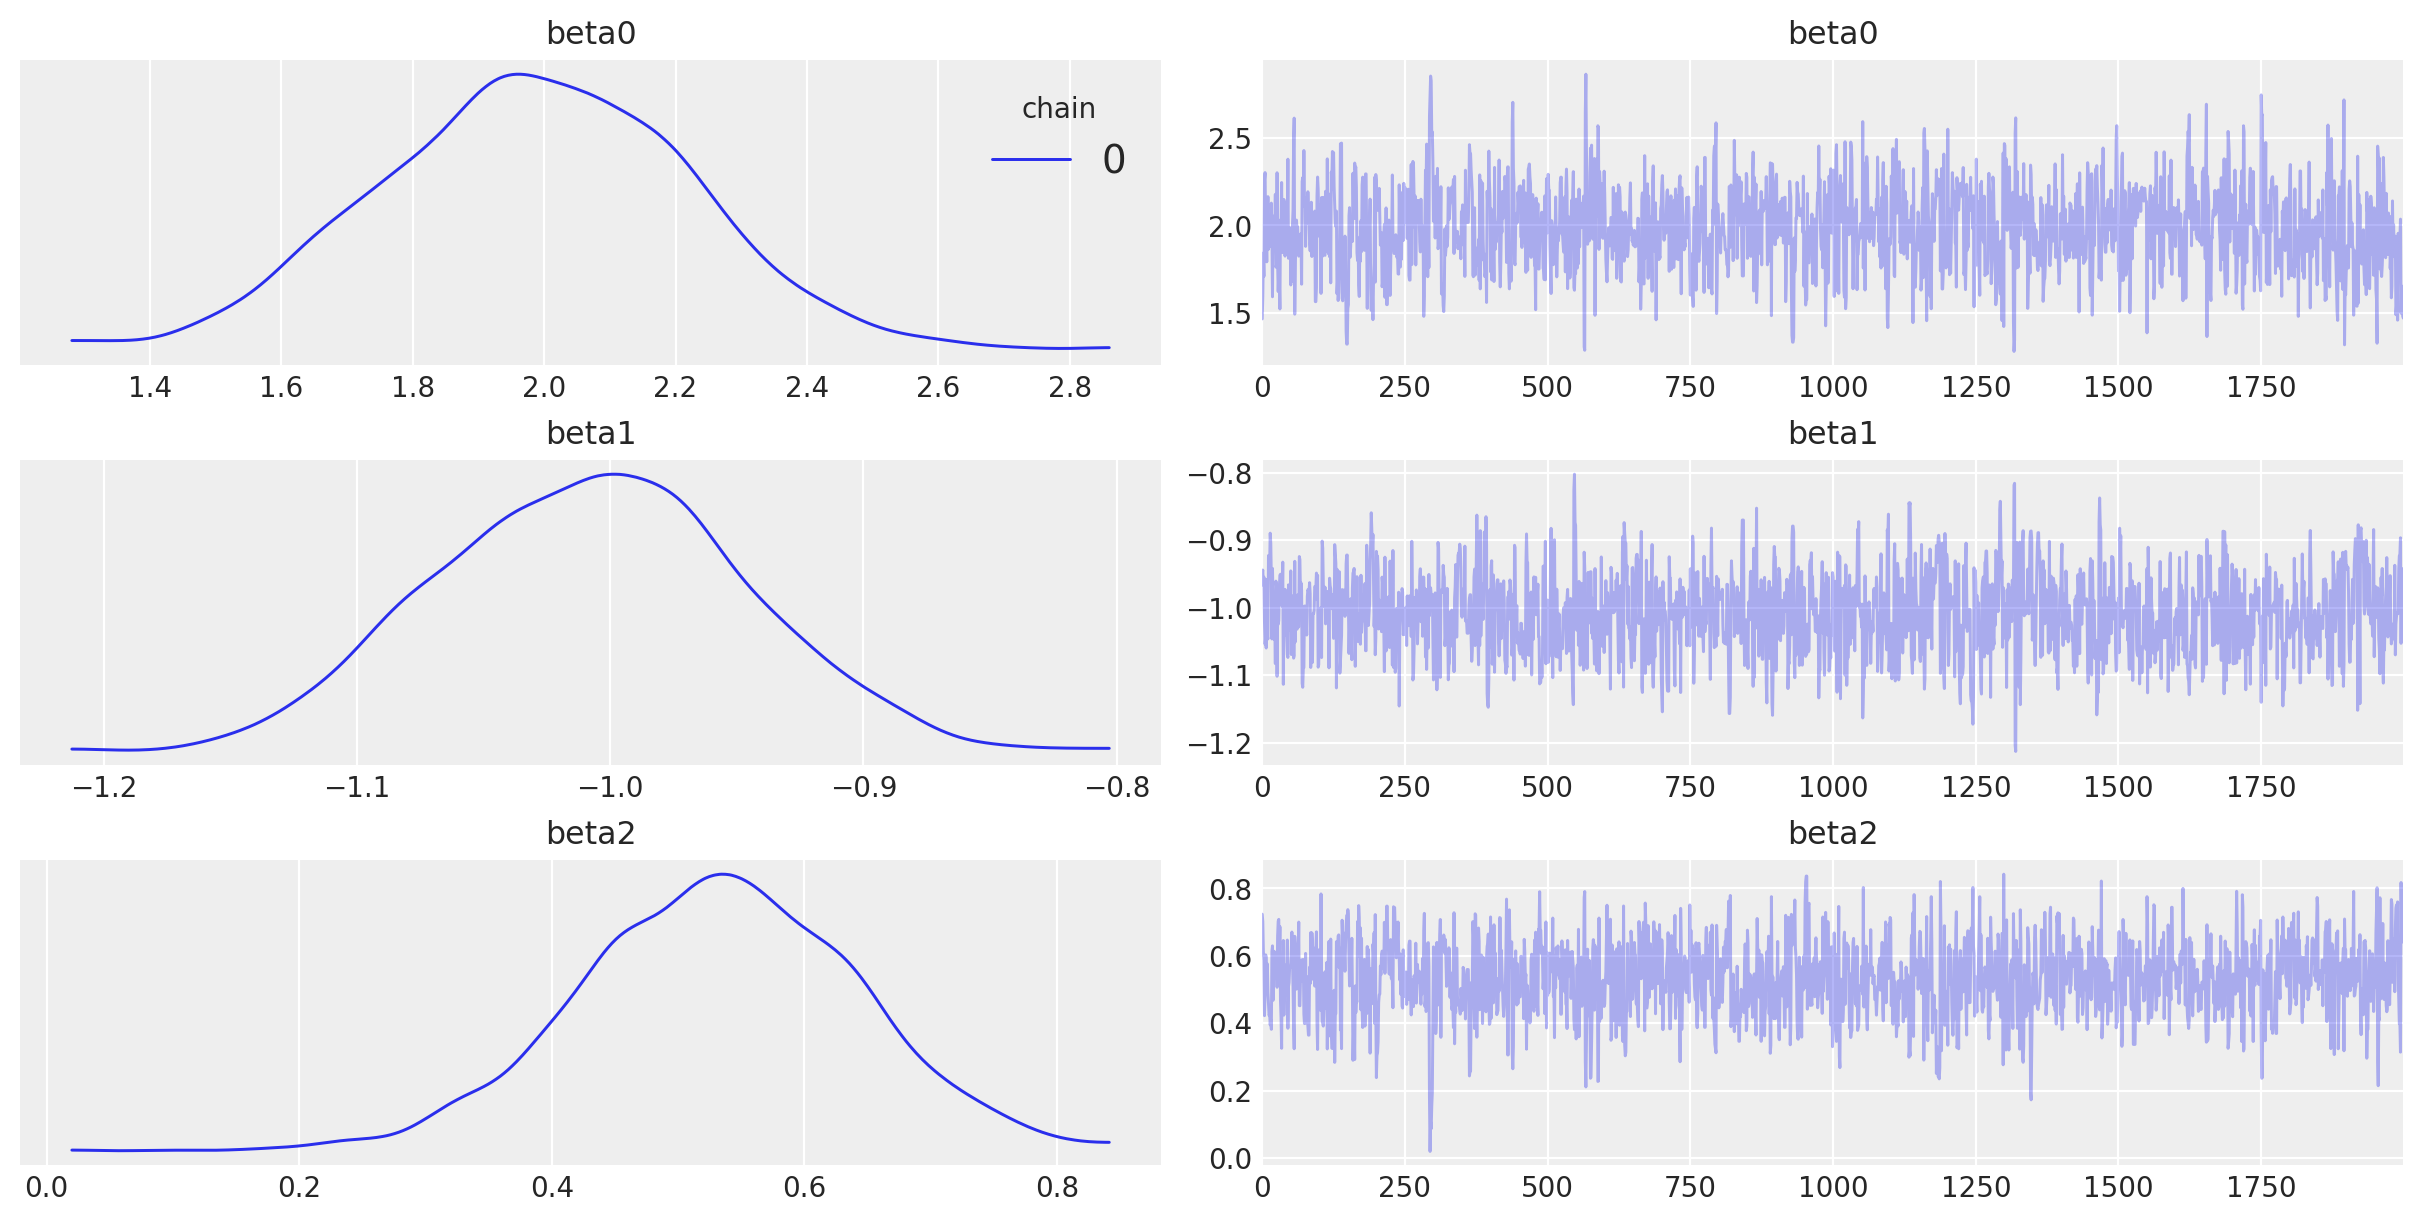

In [299]:
%%time
np.random.seed(999)

data1 = generate_sample(997)
a, _, _, _ = get_strange_estimates(data1, est=np.mean)

az.plot_trace(a, legend=True);

In [294]:
az.summary(a)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,1.679,0.230,1.228,2.087,0.006,0.004,1518.0,1528.0,1.0
beta1,-0.987,0.058,-1.086,-0.873,0.001,0.001,1806.0,1863.0,1.0
beta2,0.682,0.106,0.478,0.877,0.002,0.002,1830.0,1245.0,1.0


In [300]:
az.summary(a)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,1.985,0.240,1.536,2.424,0.008,0.005,1017.0,832.0,NaN
beta1,-1.008,0.060,-1.122,-0.900,0.002,0.001,1047.0,809.0,NaN
beta2,0.531,0.111,0.318,0.729,0.004,0.003,1016.0,771.0,NaN


In [302]:
params = ['beta0', 'beta1', 'beta2']
true_betas = [2, -1, 0.5]

def get_strange_results(size, n_epochs=100):
    
    results_bayes = {'beta0': [],
                     'beta1': [],
                     'beta2': []
                    }
    results_ml = {'beta0': [],
                  'beta1': [],
                  'beta2': []
                  }
    
    total_bayes = []
    total_ml = []
    
    for epoch in range(n_epochs):
        print('Размер выборки:', size, '------ Эпоха', epoch + 1, 'из', n_epochs)
        
        data_new = generate_sample(size)
        
        # bayes
        coefs_bayes = get_strange_estimates(data_new)
        for param in range(len(params)):
            results_bayes[params[param]].append(coefs_bayes[param])
            
        # maximum likelihood
        target = data_new['y']
        X_probit = np.vstack((np.ones(size), data_new['x_1'], data_new['x_2'])).T
        coefs_ml = Probit(target, X_probit).fit()
        for param in range(len(params)):
            results_ml[params[param]].append(coefs_ml.params[param])
        clear_output(wait=True)
        
    # подсчитываем метрики
    
    for i in range(len(params)):
        true_coef = np.ones(shape=n_epochs) * true_betas[i]
        total_bayes.append([params[i], 
                      mape(true_coef, results_bayes[params[i]]) * 100, # в процентах
                      mse(true_coef, results_bayes[params[i]], squared=False)])
        total_ml.append([params[i], 
                      mape(true_coef, results_ml[params[i]]) * 100, # в процентах
                      mse(true_coef, results_ml[params[i]], squared=False)])

    return total_bayes, total_ml


Априорные $\mathcal{N}(0, 9)$

In [303]:
np.random.seed(999)

get_strange_results(1000, n_epochs=50)

([['beta0', 10.294081183432684, 0.251641838535469],
  ['beta1', 5.673852461985284, 0.06640303714949525],
  ['beta2', 16.432842812053476, 0.10085622397626438]],
 [['beta0', 10.28706732394663, 0.25175743009089313],
  ['beta1', 5.61757141021836, 0.06570123855238173],
  ['beta2', 16.62764758444137, 0.10199672709681035]])

In [304]:
np.random.seed(999)

get_strange_results(100, n_epochs=50)

([['beta0', 30.846874500541745, 0.7875866424537694],
  ['beta1', 20.015128955887015, 0.2715345110753124],
  ['beta2', 47.81921923191354, 0.2943173814862489]],
 [['beta0', 34.362273004338135, 0.9088819450580736],
  ['beta1', 19.40028869544669, 0.27192244433471646],
  ['beta2', 46.430280866634156, 0.282019231376764]])

In [306]:
np.random.seed(999)

get_strange_results(60, n_epochs=50)

([['beta0', 45.883275046300255, 1.2004920167292474],
  ['beta1', 29.178884927418792, 0.40449726582102646],
  ['beta2', 77.49615568607325, 0.6056906861370603]],
 [['beta0', 57.26964220629538, 1.5641349847087773],
  ['beta1', 30.762944185844194, 0.4412687948962342],
  ['beta2', 78.89348416629906, 0.6042841772168839]])